# extraction données 

In [1]:

from datetime import datetime, timedelta
import pandas as pd
import backtrader as bt



full_df = pd.read_csv('us_banks.csv')

# Étape 1 : conversion explicite en datetime (si ce n'est pas déjà le cas)
full_df['date'] = pd.to_datetime(full_df['date'], errors='coerce')
# Étape 2 : enlever le fuseau horaire SANS conversion d'heure
# (on enlève tzinfo mais on garde l'heure locale telle quelle)
full_df['date'] = full_df['date'].apply(lambda dt: dt.replace(tzinfo=None) if pd.notna(dt) else dt)


# Étape 2: sélectionner les colonnes d'intérêt
cols = ['date', 'symbol', 'open', 'high', 'low', 'close', 'volume']
full_df = full_df[cols]

# Étape 3: pivot en colonnes multiples
df_wide = full_df.pivot(index='date', columns='symbol', values=['open', 'high', 'low', 'close', 'volume'])

# Étape 4: réordonner les colonnes si tu veux (facultatif)
df_wide = df_wide.reorder_levels([1, 0], axis=1).sort_index(axis=1)

# Étape 5: fixer l'index datetime
df_wide.index = pd.to_datetime(df_wide.index)




# ------------------------------------------------------------------
# 2) Fonctions utilitaires (identiques, mais génériques)
# ------------------------------------------------------------------
def prepare_for_backtrader(df_wide, symbol):
    """
    Extrait le sous-DataFrame df_wide[symbol] (colonnes OHLCV)
    et ajoute openinterest = 0 pour Backtrader.
    """
    df = df_wide[symbol].copy()
    required = ['open', 'high', 'low', 'close', 'volume']
    if not all(col in df.columns for col in required):
        missing = [c for c in required if c not in df.columns]
        raise ValueError(f"{symbol} – colonnes manquantes : {missing}")
    df['openinterest'] = 0
    df = df.dropna()
    return df[['open', 'high', 'low', 'close', 'volume', 'openinterest']]

def filter_last_days(df, n_days):
    cutoff = df.index.max() - timedelta(days=n_days)
    return df[df.index >= cutoff]


C:\Users\JEAUL2\AppData\Local\Temp\ipykernel_9936\3196832630.py:10: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  full_df['date'] = pd.to_datetime(full_df['date'], errors='coerce')


# Backtest

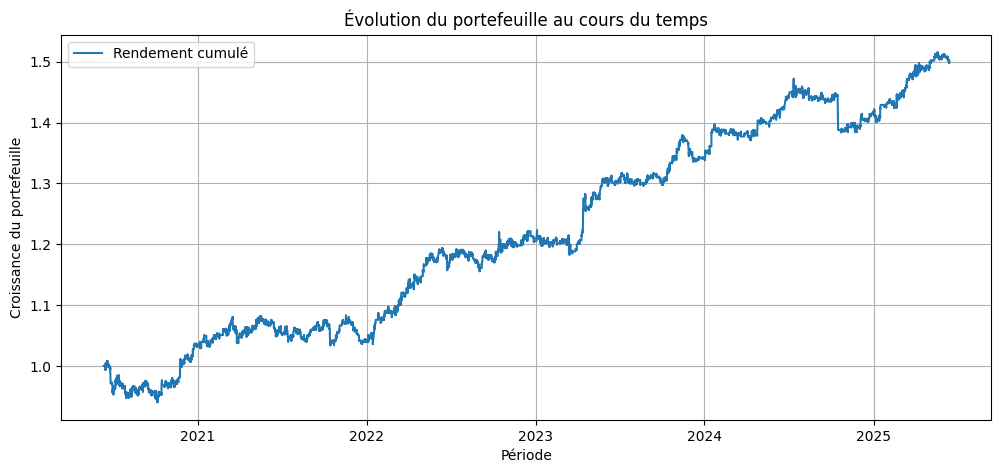

Volatilité annualisée : 0.0729
Sharpe ratio : 1.3522
Drawdown maximal : -0.0674

Fréquence des paires sélectionnées :
(MS, JPM)    1251
Name: count, dtype: int64

Nombre moyen de trades par jour : 1.11
Gain moyen : 269.1959
Perte moyenne : -251.4324
Durée moyenne des positions (h) : 0.73


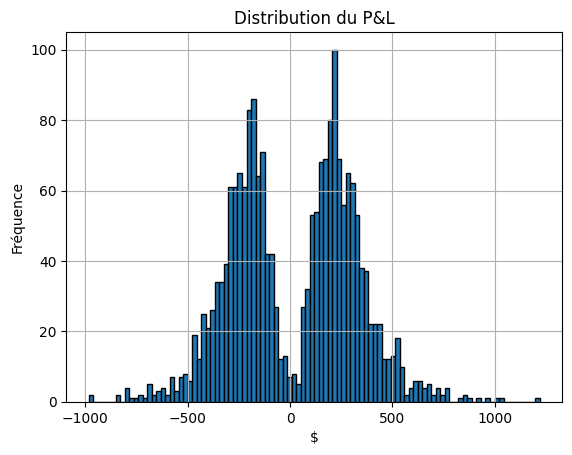

In [ ]:
from backtest import PairTradingStrategy


"""
symbols = ['JPM', 'BAC', 'C', 'WFC', 'USB',
           'PNC', 'TFC', 'GS', 'MS', 'SCHW']
"""
"""
symbols = ['JPM', 'BAC', 'C', 'WFC',
           'GS', 'MS']
"""

symbols = ['MS', 'JPM']

# ------------------------------------------------------------------
# 3) Construction du moteur Backtrader
# ------------------------------------------------------------------
cerebro = bt.Cerebro()

# a) ajouter chaque flux de données
for sym in symbols:
    data = prepare_for_backtrader(df_wide, sym)
    # ↓ optionnel – filtrer les 250 derniers jours, par ex.
    # data = filter_last_days(data, 250)
    feed = bt.feeds.PandasData(dataname=data, name=sym)
    cerebro.adddata(feed, name=sym)

# b) paramètre pour la stratégie
params_config = dict(
    stocks=symbols,
    training_day=1,
    trading_day=1,
    trade_condition=0.99,
    statistical_model=CopuleGarch
    edge_buffer=6
)

cerebro.addstrategy(PairTradingStrategy, **params_config)


# ------------------------------------------------------------------
# 4) Paramètres broker et lancement
# ------------------------------------------------------------------
cerebro.broker.setcash(100_000)
cerebro.broker.setcommission(leverage=10)

results = cerebro.run()

In [39]:
from garch import Garch
from copule_patton import CoefCorrDynamique
import openturns as ot
import numpy as np
import pandas as pd
from scipy.stats import norm, t
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from itertools import combinations
from abc import ABC, abstractmethod


from itertools import combinations

class PairSelector:
    """
    Cette classe sélectionne automatiquement la meilleure paire d'actifs
    en fonction critere
    """

    def __init__(self, df, copule):
        """
        Initialise l'objet PairSelector.

        Paramètres
        ----------
        df : pandas.DataFrame
            DataFrame contenant les rendements des actifs (chaque colonne représente un actif).
        copule : class
            Classe de la copule à utiliser (ex. CopuleStatic, CopuleGarch, CopulePatton).
            Elle doit pouvoir être instanciée sans argument : copule().
        """
        # Créer toutes les combinaisons possibles de paires d'actifs
        self.pairs = list(combinations(df.columns.tolist(), 2))

        # Dictionnaire contenant une instance de la copule pour chaque paire
        self.copule_dict = {pair: copule() for pair in self.pairs}

        # Déterminer la meilleure paire selon la log-vraisemblance
        self.best_pair = self.find_best_pair(df)

    def find_best_pair(self, df):
        """
        Évalue chaque paire en entraînant la copule sur ses données, 
        puis retourne la paire ayant la plus grande log-vraisemblance.

        Paramètres
        ----------
        df : pandas.DataFrame
            DataFrame contenant les rendements des actifs.

        Retour
        ------
        tuple
            La meilleure paire d'actifs, sous forme de tuple (actif_1, actif_2).
        """
        scores = {pair: None for pair in self.pairs}

        for pair in self.pairs:
            j, k = pair
            returns = df[[j, k]]

            # Entraîner la copule et calculer la vraisemblance
            self.copule_dict[pair].fit(returns)
            scores[pair] = self.copule_dict[pair].rho_t_moins_1 

        return max(scores, key=scores.get)

    def get_bestpair(self):
        """
        Retourne la meilleure paire sélectionnée.
        """
        return self.best_pair

    def get_copule(self):
        """
        Retourne l'objet copule associé à la meilleure paire.

        Cela permet de réutiliser directement l'objet copule dans un backtest
        sans avoir à le recalculer.

        Retour
        ------
        object
            Instance de la copule associée à la meilleure paire.
        """
        return self.copule_dict[self.best_pair]




class CopuleBase(ABC):

    def __init__(self):
        self.distribution = None
        self.copule = None
        self.marginals = None
        self.d_of_f = {} #liste degrés de libertés des lois de student
        self.rho_t_moins_1 = 0

    
    @abstractmethod
    def fit(self, df):
        """
        Entraîne la copule sur les données. Doit être implémentée par les sous-classes.
        :param df: DataFrame contenant les données à utiliser pour l’entraînement.
        """
        pass

    @abstractmethod
    def _train_copule(self, data):
        """
        Code paramétrise la copule et marge a partir données pris en argument data.
        """
        pass

    @abstractmethod
    def estimation_marginal(self, asset_name, asset_return, v):
        """
        Estime une loi de Student t pour les marges.
        Doit être implémentée par les sous-classes.
        """
        pass
    
    
    @abstractmethod
    def MI_t(self, data):
        """
        Calcule le mispricing index au temps t.
        :param data: pd.DataFrame contenant les échantillons (une colonne par actif).
        :return: probabilité conditionnelle P(U ≤ u | V = v) et P(V ≤ v | U = u)
        """
        pass
    

    def PIT(self, x, y):
        """
        Effectue la transformation PIT (Probability Integral Transform).
        :param x: Série de rendements de l'actif 1.
        :param y: Série de rendements de l'actif 2.
        :return: u, v  les valeurs transformées uniformes.
        """
        # S'assurer que x et y sont itérables
        x = np.atleast_1d(x)
        y = np.atleast_1d(y)

        u = np.array([self.marginals[0].computeCDF(xi) for xi in x])
        v = np.array([self.marginals[1].computeCDF(yi) for yi in y])

        CLIP = 1e-6
        u_raw = np.clip(u, CLIP, 1-CLIP)
        v_raw = np.clip(v, CLIP, 1-CLIP)
        return u_raw, v_raw
    

    def copule_static(self):
        R = ot.CorrelationMatrix(2)
        R[0, 1] = self.rho_t_moins_1
        R[1, 0] = self.rho_t_moins_1
        self.copule = ot.NormalCopula(R)
        self.distribution = ot.JointDistribution(self.marginals, self.copule)

    '''
    def probabilité_conditionnelle(self, data, epsilon=0.01):
        """
        Calcule simultanément
            • P(U ≤ u | V = v)
            • P(V ≤ v | U = u)
        par dérivée numérique centrale sur la copule C(u, v).

        Paramètres
        ----------
        data : pd.Series
            Série à deux composantes (valeurs x et y observées).
        epsilon : float
            Pas de dérivation (différence finie centrale).

        Retour
        ------
        tuple(float, float)
            (prob_U_cond_V, prob_V_cond_U)
        """

        # 1) transformation PIT  (u = F_X(x),  v = F_Y(y))
        vals = data.values.tolist()
        uv    = [self.distribution.getMarginal(i).computeCDF(vals[i])
                for i in range(2)]
        u, v  = uv                         # dépaquetage

        # ------------------------------------------------------------------
        # 2) P(U ≤ u | V = v)  =  ∂C(u,v)/∂v
        # ------------------------------------------------------------------
        uv_plus, uv_minus = uv.copy(), uv.copy()
        uv_plus[1]  = min(v + epsilon, 1.0)
        uv_minus[1] = max(v - epsilon, 0.0)

        cdf_plus_v  = self.copule.computeCDF(uv_plus)
        cdf_minus_v = self.copule.computeCDF(uv_minus)
        prob_u_cond_v = (cdf_plus_v - cdf_minus_v) / (2 * epsilon)

        # ------------------------------------------------------------------
        # 3) P(V ≤ v | U = u)  =  ∂C(u,v)/∂u
        # ------------------------------------------------------------------
        uv_plus, uv_minus = uv.copy(), uv.copy()
        uv_plus[0]  = min(u + epsilon, 1.0)
        uv_minus[0] = max(u - epsilon, 0.0)

        cdf_plus_u  = self.copule.computeCDF(uv_plus)
        cdf_minus_u = self.copule.computeCDF(uv_minus)
        prob_v_cond_u = (cdf_plus_u - cdf_minus_u) / (2 * epsilon)

        return prob_u_cond_v, prob_v_cond_u
    '''
    def probabilité_conditionnelle(self, data, epsilon=0.01):
        """
        Calcule simultanément :
            • P(U ≤ u | V = v)
            • P(V ≤ v | U = u)
        par dérivée numérique centrale sur la copule C(u, v).
        """

        # 1. Extraire les scalaires (float natifs)
        x, y = float(data.iloc[0]), float(data.iloc[1])
        u, v = self.PIT(x, y)
        u = float(np.asarray(u).item())
        v = float(np.asarray(v).item())
        uv = [u, v]

        # 2. ∂C/∂v
        uv_plus  = uv.copy()
        uv_minus = uv.copy()
        uv_plus[1]  = min(v + epsilon, 1.0)
        uv_minus[1] = max(v - epsilon, 0.0)

        cdf_plus_v  = self.copule.computeCDF(uv_plus)
        cdf_minus_v = self.copule.computeCDF(uv_minus)
        prob_u_cond_v = (cdf_plus_v - cdf_minus_v) / (2 * epsilon)

        # 3. ∂C/∂u
        uv_plus  = uv.copy()
        uv_minus = uv.copy()
        uv_plus[0]  = min(u + epsilon, 1.0)
        uv_minus[0] = max(u - epsilon, 0.0)

        cdf_plus_u  = self.copule.computeCDF(uv_plus)
        cdf_minus_u = self.copule.computeCDF(uv_minus)
        prob_v_cond_u = (cdf_plus_u - cdf_minus_u) / (2 * epsilon)

        return prob_u_cond_v, prob_v_cond_u



class CopuleStatic(CopuleBase):
    def __init__(self):
        super().__init__()


    def estimation_marginal(self, asset_name, asset_return, v):
        v , _, _ = t.fit(asset_return, floc=0.0, fscale=1.0)
        self.d_of_f[asset_name] = v
        return ot.Student(v, 0, 1)
    

    def fit(self, df):
        self._train_copule(df)

    
    def _train_copule(self, data):
        data = data.dropna()

        if data.shape[0] == 0:
            raise ValueError("Plus de données après suppression des NaN. Impossible d’entraîner la copule.")

        x, y = data.iloc[:,0].to_numpy(), data.iloc[:,1].to_numpy()

        self.marginals = [self.estimation_marginal(asset_name, data[asset_name], None) for asset_name in data.columns]
        u, v = self.PIT(x, y)
        z_u, z_v = norm.ppf(u), norm.ppf(v)
        self.rho_t_moins_1 = np.corrcoef(z_u, z_v)[0, 1]
        self.copule_static()#création copule static
   

  
    def MI_t(self, data):
        return self.probabilité_conditionnelle(data)
    





class CopuleGarch(CopuleBase):
    def __init__(self):
        super().__init__()
        self.garch = Garch()


    def estimation_marginal(self, asset_name, asset_return, v):
        if v is None:
            v , _, _ = t.fit(asset_return, floc=0.0, fscale=1.0)
            self.d_of_f[asset_name] = v
        return ot.Student(v, 0, 1)
    

    def fit(self, df):
        self.garch.reset_attribut()
        self.garch._train_garch(df)
        self.d_of_f = self.garch.get_doff()
        self._train_copule(self.garch.get_standardized_residuals())

    
    def _train_copule(self, data):
        data = data.dropna()

        if data.shape[0] == 0:
            raise ValueError("Plus de données après suppression des NaN. Impossible d’entraîner la copule.")

        x, y = data.iloc[:,0].to_numpy(), data.iloc[:,1].to_numpy()

        self.marginals = [self.estimation_marginal(asset_name, data[asset_name], self.d_of_f[asset_name]) for asset_name in data.columns]
        u, v = self.PIT(x, y)
        z_u, z_v = norm.ppf(u), norm.ppf(v)
        self.rho_t_moins_1 = np.corrcoef(z_u, z_v)[0, 1]
        self.copule_static()#création copule static
   
    
    def MI_t(self, data):
        data = self.garch._nouveau_residu(data)
        return self.probabilité_conditionnelle(data)




class CopulePatton(CopuleBase):
    def __init__(self):
        super().__init__()
        self.garch = Garch()
        self.p = 10 #paramètre pour le modèle de Patton
        self.omega, self.beta, self.alpha = 0, 0, 0
        self.u, self.v = [], []

    def estimation_marginal(self, asset_name, asset_return, v):
        if v is None:
            v , _, _ = t.fit(asset_return, floc=0.0, fscale=1.0)
            self.d_of_f[asset_name] = v
        return ot.Student(v, 0, 1)
    

    def fit(self, df):
        self.garch.reset_attribut()
        self.garch._train_garch(df)
        self.d_of_f = self.garch.get_doff()
        self._train_copule(self.garch.get_standardized_residuals())

    
    def _train_copule(self, data):
        data = data.dropna()

        if data.shape[0] == 0:
            raise ValueError("Plus de données après suppression des NaN. Impossible d’entraîner la copule.")

        x, y = data.iloc[:,0].to_numpy(), data.iloc[:,1].to_numpy()

        self.marginals = [self.estimation_marginal(asset_name, data[asset_name], self.d_of_f[asset_name]) for asset_name in data.columns]
        #estimation parametre dynamique copule
        u, v = self.PIT(x, y)
        self.rho_t_moins_1 = np.corrcoef(u, v)[0, 1]
        copule_dyn =  CoefCorrDynamique(u, v, self.p)
        self.omega, self.beta, self.alpha = copule_dyn.get_params()
   

    def rho_t(self, u, v):
        if self.omega is None:
          #l'optimisation de patton n'a pas convergé on utilise parametre static
          return self.rho_t_moins_1
        self.u.append(u); self.v.append(v)

        # première obs
        if len(self.u) == 1:
            return self.rho_t_moins_1

        CLIP = 1e-6
        u_raw = np.clip(self.u[-self.p:-1], CLIP, 1-CLIP)
        v_raw = np.clip(self.v[-self.p:-1], CLIP, 1-CLIP)

        u_ppf = norm.ppf(u_raw)
        v_ppf = norm.ppf(v_raw)
        ma = np.mean(u_ppf * v_ppf)

        rho = CoefCorrDynamique.logistic_modified(
            self.omega + self.beta * self.rho_t_moins_1 + self.alpha * ma
        )
        rho = np.clip(rho, -1+1e-6, 1-1e-6)
        self.rho_t_moins_1 = rho
        return rho


    def copule_t(self, u, v):
        #ce code va servir a paramétriser la copule pour le temps t et ainsi la distribution lorsque on est dans le cas dynamique
        #u, v les pseudo observations out of sample

        #rho de t estimer model patton
        rho = self.rho_t(u, v)
        R = ot.CorrelationMatrix(2)
        R[0, 1] = rho
        R[1, 0] = rho  

        # 2. Construire la copule normale avec cette matrice
        self.copule = ot.NormalCopula(R)
        self.distribution = ot.JointDistribution(self.marginals, self.copule)

    
    def MI_t(self, data):
        data = self.garch._nouveau_residu(data)
        x, y = data.iloc[0], data.iloc[1]
        u, v = self.PIT(x, y)
        self.copule_t(u, v)

        return self.probabilité_conditionnelle(data)
  

[autoreload of backtest failed: Traceback (most recent call last):
  File "C:\Users\JEAUL2\AppData\Roaming\Python\Python311\site-packages\IPython\extensions\autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\JEAUL2\AppData\Roaming\Python\Python311\site-packages\IPython\extensions\autoreload.py", line 483, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "c:\Users\JEAUL2\AppData\Local\Programs\Python\Python311\Lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "c:\Users\JEAUL2\Documents\stat_arb\backtest.py", line 10, in <module>
    class PairTradingStrategy(bt.Strategy):
  File "c:\Users\JEAUL2\Documents\stat_arb\backtest.py", line 16, in PairTradingStrategy
    st

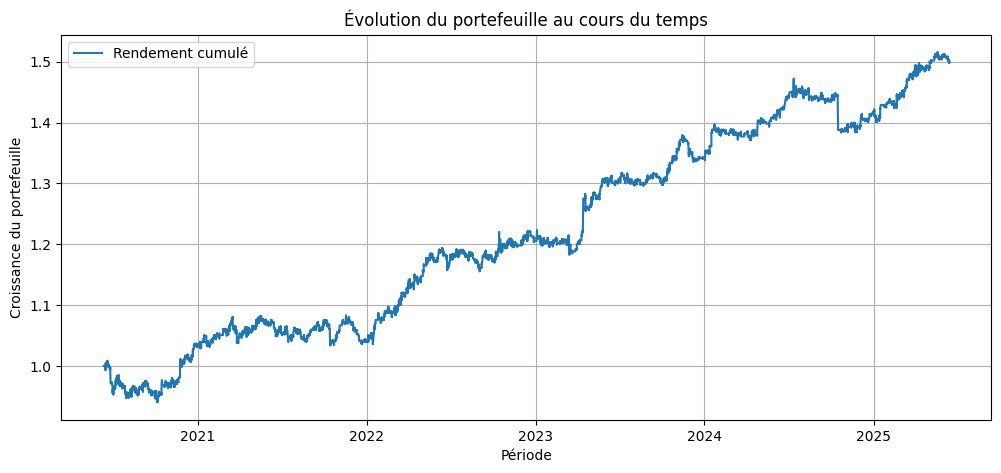

Volatilité annualisée : 0.0729
Sharpe ratio : 1.3522
Drawdown maximal : -0.0674

Fréquence des paires sélectionnées :
(MS, JPM)    1251
Name: count, dtype: int64

Nombre moyen de trades par jour : 1.11
Gain moyen : 269.1959
Perte moyenne : -251.4324
Durée moyenne des positions (h) : 0.73


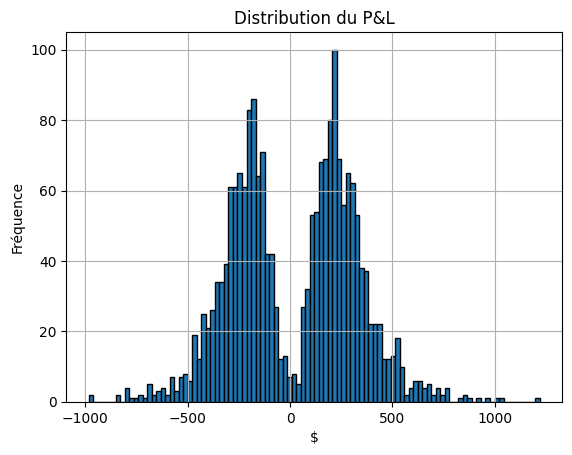

In [38]:
import backtrader as bt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



class PairTradingStrategy(bt.Strategy):
    params = dict(
        training_day=1,
        trading_day=1,
        timeframe=5,             # minutes
        trade_condition=0.99,    # seuil sur le MI
        statistical_model=CopuleGarch,
        stocks=[],                # noms des datafeeds
        edge_buffer = 6
    )

    def __init__(self):
        # datafeeds indexés par nom
        self.stocks = {name: self.getdatabyname(name) for name in self.params.stocks}
        self.stock_a, self.stock_b = None, None       # mis à jour par PairSelector
        self.copule = None
        
        self.pair_history = []     # historique des paires sélectionnées
        self.trade_results = []    # PnL de chaque trade
        self.trade_durations = []  # durée de chaque position (en heures)

        self.trade_log = []
        self.mispricing = []
        self.active_stock = False
        self.trade_direction = None

        self.jour_precedent = None
        self.nb_jours_depuis_training = 0
        self.start_strat = False
        self.close_mkt = False

        self.equity_curve = []
        self.dates = []

        self.nb_chandelles = int((6.5 * 60) / self.params.timeframe)
        self.tradesize = self.broker.getvalue()

        self.tp = self.sl = 0
        self.pnl_trade = []
        self.pnl_start = 0


    # ------------------------------------------------------------------ #
    #  Utilitaires
    # ------------------------------------------------------------------ #
    def market_close(self):
        #derniere bougie a 15h55 et le close c'Est à 16h
        dt = self.datas[0].datetime.datetime(0)
        self.close_mkt = (dt.hour == 15 and dt.minute == 55)


    def count_days_since_training(self):
        d = self.datas[0].datetime.date(0)
        if self.jour_precedent is None:
            self.jour_precedent = d
        elif d != self.jour_precedent:
            self.nb_jours_depuis_training += 1
            self.jour_precedent = d

    def convert_to_return(self, kind='df', subset=None):
        if subset is None:
            subset = self.stocks.keys()

        if kind == 'df':
            n = self.params.training_day * self.nb_chandelles
            closes = np.column_stack([self.stocks[name].close.get(size=n) for name in subset])
            opens  = np.column_stack([self.stocks[name].open.get(size=n)  for name in subset])
            rets = ((closes[self.params.edge_buffer:-self.params.edge_buffer] - opens[self.params.edge_buffer:-self.params.edge_buffer]) / opens[self.params.edge_buffer:-self.params.edge_buffer]) * 100
            return pd.DataFrame(rets, columns=subset)

        elif kind == 'series':
            return pd.Series({
                name: (((self.stocks[name].close[0] - self.stocks[name].open[0]) / self.stocks[name].open[0]))  * 100
                for name in subset
            })
        else:
            raise ValueError("kind must be either 'df' or 'series'")

    def is_edge_bar(self):
        """
        Retourne True si la bougie courante (self.datas[0]) est
        dans les `buffer` premières ou dernières bougies de la journée.
        """
        dt = self.datas[0].datetime.datetime(0)
        timeframe = self.params.timeframe
        buffer = self.params.edge_buffer

        # ouverture et fermeture de la séance
        session_open = 9 * 60 + 30  # 9h30 = 570
        session_close = 16 * 60     # 16h00 = 960
        session_len = session_close - session_open  # 390 min

        nb_bars = session_len // timeframe

        now_min = dt.hour * 60 + dt.minute
        idx = (now_min - session_open) // timeframe

        return idx < buffer or idx >= nb_bars - buffer



    # ------------------------------------------------------------------ #
    #  Entraînement et sélection de la meilleure paire
    # ------------------------------------------------------------------ #
    def select_pair_and_train(self):
        train_df = self.convert_to_return('df')
        selector = PairSelector(train_df,
                                self.params.statistical_model)
        self.stock_a, self.stock_b = selector.get_bestpair()
        self.copule = selector.get_copule()
        self.pair_history.append((self.stock_a, self.stock_b))


    def fit_copule(self):
        self.market_close()
        self.count_days_since_training()

        if not self.start_strat:
            if self.nb_jours_depuis_training >= self.params.training_day-1 and self.close_mkt:
                self.select_pair_and_train()
                self.start_strat = True
                self.nb_jours_depuis_training = 0
            else:
                return True  # pas encore prêt à trader

        elif self.nb_jours_depuis_training >= self.params.trading_day-1 and self.close_mkt:
            self.select_pair_and_train()
            self.nb_jours_depuis_training = 0



    # ------------------------------------------------------------------ #
    #  Gestion des positions
    # ------------------------------------------------------------------ #
    def spread_return(self):
        da = self.stocks[self.stock_a]
        db = self.stocks[self.stock_b]
        ret_a = (da.close[0] - da.open[0]) / da.open[0]
        ret_b = (db.close[0] - db.open[0]) / db.open[0]
        return ret_a - ret_b

    def open_trade(self, longue, short):
        price_long = longue.close[0]
        price_short = short.close[0]
        qty_long = int(self.tradesize / price_long)
        qty_short = int(self.tradesize / price_short)

        self.buy(data=longue, size=qty_long)
        self.sell(data=short, size=qty_short)
        self.active_stock = True

        self.entry_datetime = self.datas[0].datetime.datetime(0)
        self.entry_prices = dict(
            long_asset=longue._name, long_price=price_long,
            short_asset=short._name, short_price=price_short,
            qty_long=qty_long, qty_short=qty_short
        )

        r = abs(self.spread_return())
        self.tp = self.sl = r
        self.pnl_trade = []
        self.pnl_start = self.broker.getvalue()


    def close_trade(self, end_of_the_day=None):
        exit_datetime = self.datas[0].datetime.datetime(0)

        duration = (exit_datetime - self.entry_datetime).total_seconds() / 3600
        self.trade_durations.append(duration)

        pnl = self.broker.getvalue() - self.pnl_start
        self.trade_results.append(pnl)

        self.trade_log.append({
            'entry_time': self.entry_datetime,
            'exit_time': exit_datetime,
            'long_asset': self.entry_prices['long_asset'],
            'short_asset': self.entry_prices['short_asset'],
            'entry_long_price': self.entry_prices['long_price'],
            'entry_short_price': self.entry_prices['short_price'],
            'qty_long': self.entry_prices['qty_long'],
            'qty_short': self.entry_prices['qty_short'],
            'pnl': pnl
        })

        if end_of_the_day is not None: #fin de la journée trading cloturé à 16h
          self.close(data=self.stock_a, exectype=bt.Order.Close)
          self.close(data=self.stock_b, exectype=bt.Order.Close)
        else:
          self.close(data=self.stock_a)
          self.close(data=self.stock_b)

        self.active_stock = False
        self.tp = self.sl = 0
        self.pnl_trade = []
        self.trade_direction = None

    # ------------------------------------------------------------------ #
    #  Boucle principale de Backtrader
    # ------------------------------------------------------------------ #
    def next(self):
        if self.fit_copule():
            return

        if self.is_edge_bar():
          #la dans ce code on attend juste qu'au close pour fermer position
          if self.active_stock and  self.close_mkt:
            self.close_trade('fin de journée! fermer toutes les positions')
          return

        data = self.convert_to_return('series', [self.stock_a, self.stock_b])
        p_u_cond_v , p_v_cond_u = self.copule.MI_t(data)
        if not self.active_stock:
          if not self.close_mkt:#ici je vais pouvoir mettre le truc de buffer_edge mais pour l'isntant si on est en fin journée
            if p_u_cond_v >= self.params.trade_condition and  p_v_cond_u <= 1 - self.params.trade_condition:
                self.open_trade(self.stocks[self.stock_b], self.stocks[self.stock_a])
                self.trade_direction = "short"
            elif p_v_cond_u >= self.params.trade_condition and p_u_cond_v <= 1 - self.params.trade_condition:
                self.open_trade(self.stocks[self.stock_a], self.stocks[self.stock_b])
                self.trade_direction = "long"

        else:#en position
            self.pnl_trade.append(self.spread_return())
            pnl = sum(self.pnl_trade)

            if self.trade_direction == "long":
                if pnl <= -self.sl or pnl >= self.tp:
                    self.close_trade()

            else:
                if pnl >= self.sl or pnl <= -self.tp:
                    self.close_trade()

        self.equity_curve.append(self.broker.getvalue())
        self.dates.append(self.datas[0].datetime.date(0))

    # ------------------------------------------------------------------ #
    #  Analyse des performances
    # ------------------------------------------------------------------ #
    def stop(self):
        equity = pd.Series(self.equity_curve, index=self.dates)
        returns = equity.pct_change().dropna()

        # Tracer la courbe de rendement cumulé
        cumulative_returns = (1 + returns).cumprod()
        plt.figure(figsize=(12, 5))
        plt.plot(cumulative_returns, label="Rendement cumulé")
        plt.xlabel("Période")
        plt.ylabel("Croissance du portefeuille")
        plt.title("Évolution du portefeuille au cours du temps")
        plt.grid(True)
        plt.legend()
        plt.show()

        annual_factor = np.sqrt(252 * (6.5 * 60 / self.params.timeframe))
        volatility = returns.std() * annual_factor
        sharpe = returns.mean() / returns.std() * annual_factor
        cumulative = (1 + returns).cumprod()
        rolling_max = cumulative.cummax()
        drawdown = (cumulative - rolling_max) / rolling_max
        max_drawdown = drawdown.min()

        print(f"Volatilité annualisée : {volatility:.4f}")
        print(f"Sharpe ratio : {sharpe:.4f}")
        print(f"Drawdown maximal : {max_drawdown:.4f}")

        if self.pair_history:
            print("\nFréquence des paires sélectionnées :")
            print(pd.Series(self.pair_history).value_counts())

        if self.trade_results:
            results = pd.Series(self.trade_results)
            avg_gain = results[results > 0].mean()
            avg_loss = results[results < 0].mean()
            avg_duration = np.mean(self.trade_durations)
            total_days = (self.dates[-1] - self.dates[0]).days
            trades_per_day = len(results) / total_days if total_days > 0 else np.nan

            print(f"\nNombre moyen de trades par jour : {trades_per_day:.2f}")
            print(f"Gain moyen : {avg_gain:.4f}")
            print(f"Perte moyenne : {avg_loss:.4f}")
            print(f"Durée moyenne des positions (h) : {avg_duration:.2f}")

            results.plot.hist(bins=100, edgecolor='black')
            plt.title("Distribution du P&L")
            plt.xlabel("$")
            plt.ylabel("Fréquence")
            plt.grid(True)
            plt.show()
        else:
            print("\nAucun trade effectué.")





symbols = ['MS', 'JPM']

# ------------------------------------------------------------------
# 3) Construction du moteur Backtrader
# ------------------------------------------------------------------
cerebro = bt.Cerebro()

# a) ajouter chaque flux de données
for sym in symbols:
    data = prepare_for_backtrader(df_wide, sym)
    # ↓ optionnel – filtrer les 250 derniers jours, par ex.
    # data = filter_last_days(data, 250)
    feed = bt.feeds.PandasData(dataname=data, name=sym)
    cerebro.adddata(feed, name=sym)

# b) paramètre pour la stratégie
params_config = dict(
    stocks=symbols,
    training_day=1,
    trading_day=1,
    trade_condition=0.99,
    statistical_model=CopuleGarch,
    edge_buffer=6
)

cerebro.addstrategy(PairTradingStrategy, **params_config)


# ------------------------------------------------------------------
# 4) Paramètres broker et lancement
# ------------------------------------------------------------------
cerebro.broker.setcash(100_000)
cerebro.broker.setcommission(leverage=10)

results = cerebro.run()